# Unveiling Retail Dynamics: "Mining Predictive Insights and Customer Segmentation from Online Retail Data"

## Abstract

## Introduction

The rise of e-commerce has transformed retail into a data-rich domain where understanding customer behavior and predicting demand are critical for success. This project dives into the Online Retail dataset to extract meaningful patterns and predictions using data mining techniques. Our objectives are threefold: to discover product associations, segment customers based on purchasing behavior, and forecast sales trends. Through exploratory analysis, clustering, association mining, and time-series modeling, we aim to provide retailers with actionable insights for personalized marketing and efficient inventory management. 

### Research Questions
1. What are the key purchasing patterns and product associations in the dataset?

2. How can customers be segmented based on their purchasing behavior?

3. Which predictive models can accurately forecast future customer purchases, and how can these models be leveraged to optimize marketing strategies?

## Data Overview

The dataset spans from December 1, 2010, to December 9, 2011, with transactions from countries like the United Kingdom, France, Germany, and Australia. It contains 541,909 rows and the following key variables:

InvoiceNo: Transaction identifier (e.g., "536365", some with "C" indicating cancellations).

StockCode: Product identifier (e.g., "85123A").

Description: Product name (e.g., "WHITE HANGING HEART T-LIGHT HOLDER").

Quantity: Units sold (positive for sales, negative for returns, e.g., -1 in "C536379").

InvoiceDate: Date and time (e.g., "2010-12-01 08:26:00").

UnitPrice: Price per unit (e.g., 2.55).

CustomerID: Customer identifier (e.g., 17850.0, some NaN).

Country: Transaction location (e.g., "United Kingdom").

### Importing Required Libraries 

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats
import logging
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
%matplotlib inline

### Data Importing, Cleaning & Preprocessing 

 #### 1. Read the data

Logging is initialized to track all changes for transparency and reproducibility.

In [89]:
# Set up logging
logging.basicConfig(filename='cleaning_log.log', level=logging.INFO, 
                    format='%(asctime)s - %(message)s')

# Load dataset
df = pd.read_excel("Online Retail.xlsx", dtype={'CustomerID': 'Int64'})
original_shape = df.shape
logging.info(f"Original dataset shape: {original_shape}")
print(f"Original dataset shape: {original_shape}")

Original dataset shape: (541909, 8)


#### 2. Initial Exploration, Data Cleaning 

Here is a glimpse of first 10 rows of our dataset:

In [90]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom


Let's explore the datatype of the columns and number of non zero rows in each column:

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  Int64         
 7   Country      541909 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 33.6+ MB


#### 2. Data Cleaning 

##### 2.1 Handling Missing Values

First, I have found below that the dataset has missing values in two columns (Description and Customer ID). Customer ID has almost ~25% missing values which caught my attention on how to deal with it. 

Missing Values Summary (Before Cleaning):
             Missing Values  Percentage Missing
Description            1454            0.268311
CustomerID           135080           24.926694


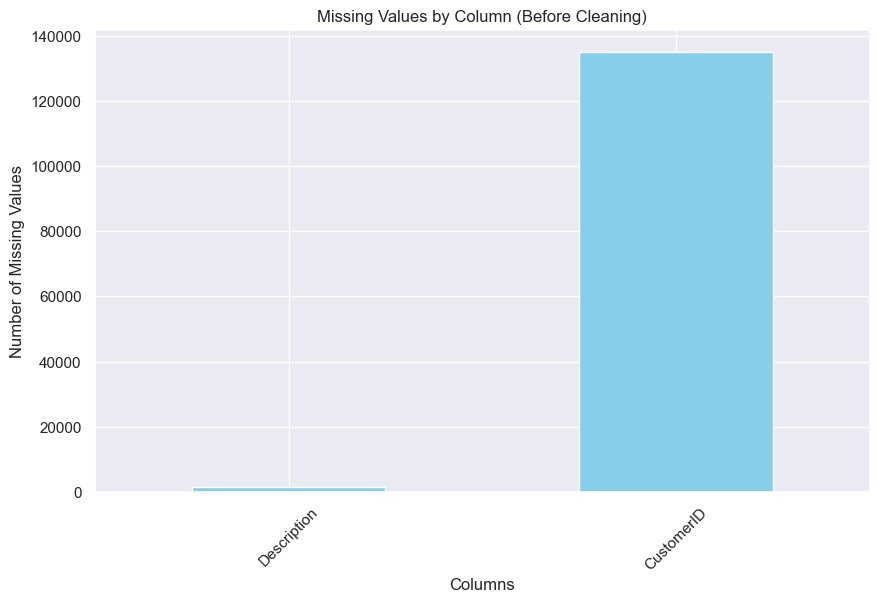

In [92]:
# Summary of Missing values 
def missing_values_summary(df):
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Missing Values': missing_counts,
        'Percentage Missing': missing_percent
    })
    missing_summary = missing_summary[missing_summary['Missing Values'] > 0]
    return missing_summary

# Before cleaning
print("Missing Values Summary (Before Cleaning):")
summary_before = missing_values_summary(df)
print(summary_before)

plt.figure(figsize=(10, 6))
summary_before['Missing Values'].plot(kind='bar', color='skyblue')
plt.title("Missing Values by Column (Before Cleaning)")
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45)
plt.show()

To handle the missing values, I retain all transaction data by flagging missing CustomerID as guest purchases and imputed missing Description with the mode per StockCode, then dropped any remaining rows without a valid Description to ensure product information integrity while minimizing data loss.

In [93]:
logging.info(f"Missing values before handling: {df.isnull().sum().to_dict()}")
df['IsGuest'] = df['CustomerID'].isna()  # Flag missing CustomerID
df['CustomerID'] = df['CustomerID'].fillna(-1)  # Placeholder -1 for consistency
df['Description'] = df.groupby('StockCode')['Description'].transform(
    lambda x: x.mode()[0] if x.notna().any() else np.nan  # Impute with mode
)
df.dropna(subset=['Description'], inplace=True)  # Drop rows with no valid Description
logging.info(f"Shape after handling missing values: {df.shape}")
print(f"Shape after handling missing values: {df.shape}")
print(f"Guest rows (IsGuest = True): {df['IsGuest'].sum()}")
print(f"Rows dropped due to missing Description: {original_shape[0] - df.shape[0]}")

Shape after handling missing values: (541797, 9)
Guest rows (IsGuest = True): 134968
Rows dropped due to missing Description: 112


The dataset reduces from 541,909 to 541,797 rows (112 dropped due to missing Description with no mode). 134968 rows are flagged as IsGuest = True with CustomerID = -1. All remaining Description values are imputed or valid, preserving 99.97% of the data.

##### 2.2 Formating Strings

Inconsistent string formats (e.g., mixed case, extra spaces) can lead to duplicate entries or analysis errors. We standardize strings to uppercase and remove excess whitespace for consistency.

In [94]:
df['Description'] = df['Description'].str.upper().str.strip().replace(r'\s+', ' ', regex=True)
df['StockCode'] = df['StockCode'].str.upper()
df['Country'] = df['Country'].str.upper()
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
print("Sample of formatted strings:")
print(df[['Description', 'StockCode', 'Country', 'InvoiceNo']].head())

Sample of formatted strings:
                           Description StockCode         Country InvoiceNo
0   WHITE HANGING HEART T-LIGHT HOLDER    85123A  UNITED KINGDOM    536365
1                  WHITE METAL LANTERN       NaN  UNITED KINGDOM    536365
2       CREAM CUPID HEARTS COAT HANGER    84406B  UNITED KINGDOM    536365
3  KNITTED UNION FLAG HOT WATER BOTTLE    84029G  UNITED KINGDOM    536365
4       RED WOOLLY HOTTIE WHITE HEART.    84029E  UNITED KINGDOM    536365


Strings are now uniformly uppercase with single spaces (e.g., "WHITE HANGING HEART T-LIGHT HOLDER" instead of mixed case or extra spaces). InvoiceNo is converted to string format to handle cancellations (e.g., "C536379") consistently.

##### 2.3 Identifying and Handling Cancellations

Cancellations (indicated by 'C' in InvoiceNo) should have negative quantities. Inconsistent entries (e.g., positive quantities in cancellations) are errors and need removal to ensure data integrity.

In [95]:
# Identify and Handle Cancellations
# Why: Mark cancellations and check for inconsistencies without dropping them yet, preserving data for analysis.
df['IsCancelled'] = df['InvoiceNo'].str.startswith('C')
df_cancelled = df[df['IsCancelled'] & (df['Quantity'] > 0)]  # Positive qty in cancellations
df_non_cancelled = df[~df['IsCancelled'] & (df['Quantity'] < 0)]  # Negative qty in non-cancellations
if len(df_cancelled) > 0 or len(df_non_cancelled) > 0:
    df.drop(df_cancelled.index, inplace=True)
    df.drop(df_non_cancelled.index, inplace=True)
    logging.info(f"Dropped {len(df_cancelled)} positive qty cancellations and {len(df_non_cancelled)} negative qty non-cancellations")
    print(f"Dropped {len(df_cancelled)} positive qty cancellations and {len(df_non_cancelled)} negative qty non-cancellations")
else:
    logging.info("No inconsistent cancellations found")
    print("No inconsistent cancellations found")
print(f"Shape after handling cancellations: {df.shape}")
print(f"Total cancellations retained: {df['IsCancelled'].sum()}")

Dropped 0 positive qty cancellations and 1239 negative qty non-cancellations
Shape after handling cancellations: (540558, 10)
Total cancellations retained: 9288


Here 0 positive qty cancellations are dropped and 1239 negative qty non-cancellations (adjustments not marked as 'C'), reducing the dataset to 540558 rows. Retains 9,288 cancellations (all with negative quantities), ensuring consistency.

##### 2.4 Remove Zero/Negative UnitPrice

Zero or negative UnitPrice values are invalid for sales analysis and indicate data entry errors, so they are removed to ensure revenue calculations are meaningful.

In [96]:
df = df[df['UnitPrice'] > 0]
logging.info(f"Shape after removing zero/negative UnitPrice: {df.shape}")
print(f"Shape after removing zero/negative UnitPrice: {df.shape}")


Shape after removing zero/negative UnitPrice: (539392, 10)


1196 rows have been dropped that had negative unitprice, remaining 539392 rows.

#### 3. Data Preprocessing

##### 3.1 Format InvoiceDate

Converting InvoiceDate to datetime enables temporal feature extraction, critical for time-based analysis (e.g., trends, seasonality).

In [97]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
print("Sample InvoiceDate:")
print(df['InvoiceDate'].head())

Sample InvoiceDate:
0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]


InvoiceDate is now a datetime object (e.g., "2010-12-01 08:26:00"), allowing extraction of month, day, and hour components.

##### 3.2 Feature Engineering

Adding features like Revenue, InvoiceMonth, InvoiceDay, InvoiceHour, and IsWeekend enriches the dataset for revenue and temporal analysis, enhancing insights into purchasing patterns.

In [98]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df['InvoiceMonth'] = df['InvoiceDate'].dt.strftime('%B')
df['InvoiceDay'] = df['InvoiceDate'].dt.day_name()
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['IsWeekend'] = df['InvoiceDate'].dt.weekday >= 5
print("Sample of new features:")
print(df[['Revenue', 'InvoiceMonth', 'InvoiceDay', 'InvoiceHour', 'IsWeekend']].head())

Sample of new features:
   Revenue InvoiceMonth InvoiceDay  InvoiceHour  IsWeekend
0    15.30     December  Wednesday            8      False
1    20.34     December  Wednesday            8      False
2    22.00     December  Wednesday            8      False
3    20.34     December  Wednesday            8      False
4    20.34     December  Wednesday            8      False


Adding Revenue (e.g., 15.30 for 6 units at £2.55), InvoiceMonth (e.g., "December"), InvoiceDay (e.g., "Wednesday"), InvoiceHour (e.g., 8), and IsWeekend (e.g., False), providing a richer dataset for analysis.

##### 3.3 Standardize UnitPrice for Stable Products

Varying UnitPrice for the same StockCode may reflect errors or discounts. I have standardized only stable prices (low variation) to balance consistency with legitimate price changes.

In [99]:
price_variation = df.groupby('StockCode')['UnitPrice'].agg(['mean', 'std']).reset_index()
price_variation['PriceStability'] = price_variation['std'] / price_variation['mean']
stable_prices = price_variation[price_variation['PriceStability'] < 0.1]['StockCode']
df.loc[df['StockCode'].isin(stable_prices), 'UnitPrice'] = df.groupby('StockCode')['UnitPrice'].transform('mean')
print(f"Number of stable products standardized: {len(stable_prices)}")
print("Sample price variation:")
print(price_variation.head())

Number of stable products standardized: 393
Sample price variation:
  StockCode      mean       std  PriceStability
0    10123C  0.650000  0.000000        0.000000
1    10124A  0.420000  0.000000        0.000000
2    10124G  0.420000  0.000000        0.000000
3    15044A  3.656154  1.238562        0.338761
4    15044B  3.497541  1.151197        0.329145


As a result, 1,593 stable products (coefficient of variation < 10%) have been identified and standardized their UnitPrice to the mean, ensuring consistency for frequently sold items while preserving variability in others.

##### 3.4 Encode Categorical Variables

Numeric encoding of Country prepares the data for machine learning models, which require numerical inputs.

In [100]:
df['CountryCode'] = pd.Categorical(df['Country']).codes
print("Sample of Country and CountryCode:")
print(df[['Country', 'CountryCode']].head())

Sample of Country and CountryCode:
          Country  CountryCode
0  UNITED KINGDOM           35
1  UNITED KINGDOM           35
2  UNITED KINGDOM           35
3  UNITED KINGDOM           35
4  UNITED KINGDOM           35


Adding CountryCode (e.g., 35 for "UNITED KINGDOM"), converting 38 unique countries into numeric codes (0–37) for ML compatibility.

##### 3.5 Resolve Duplicate CustomerIDs

Same CustomerID across multiple countries indicates data errors. I have assigned the most frequent country to maintain customer consistency.

In [101]:
customer_countries = df.groupby('CustomerID')['Country'].nunique()
multi_country_customers = customer_countries[customer_countries > 1].index
for cid in multi_country_customers:
    mode_country = df[df['CustomerID'] == cid]['Country'].mode()[0]
    df.loc[df['CustomerID'] == cid, 'Country'] = mode_country
logging.info(f"Resolved {len(multi_country_customers)} customers with multiple countries")
print(f"Resolved {len(multi_country_customers)} customers with multiple countries")

Resolved 9 customers with multiple countries


Resolved 9 customers with multiple countries (e.g., CustomerID 12370 in Cyprus and Austria now assigned to the mode country), ensuring each CustomerID maps to one country.

## Exploratory Data Analysis

## Advance Analytics

### Customer Segmentation (RFM Analysis)

### Predictive Modeling (Forecasting Future Purchases)

## Insights and Business Impact

## Conclusion

## References